In [24]:
# 1. Import Libraries

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# nltk.download("stopwords")
# nltk.download("wordnet")

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [29]:
# 2. Load Data

train_df = pd.read_csv("../data/twitter_training.csv", header=None, names=["id","entity","sentiment","text"])
test_df  = pd.read_csv("../data/twitter_validation.csv", header=None, names=["id","entity","sentiment","text"])

train_df.head(5000)

,id,entity,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
4995,58,Amazon,Neutral,@OregonChai did finally stop making the sugar ...
4996,58,Amazon,Neutral,@OregonChai What did y ’ all really stop makin...
4997,58,Amazon,Neutral,@OregonChai did y’all stop making the butter<u...
4998,59,Amazon,Neutral,Amazon UK launches the Sherlock Holmes Advent ...


In [31]:
test_df.head(1000)

,id,entity,sentiment,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [12]:
# 3. Preprocessing

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', str(text))
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.lower().split()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
    return " ".join(text)

train_df["clean_text"] = train_df["text"].apply(clean_text)
test_df["clean_text"]  = test_df["text"].apply(clean_text)

train_df = train_df[train_df["sentiment"].isin(["Positive","Negative"])]
test_df  = test_df[test_df["sentiment"].isin(["Positive","Negative"])]


In [13]:
# 4. TF-IDF + Logistic Regression

X_train, X_val, y_train, y_val = train_test_split(
    train_df["clean_text"], train_df["sentiment"], test_size=0.2, random_state=42
)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf   = vectorizer.transform(X_val)

log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train_tfidf, y_train)

y_pred = log_reg.predict(X_val_tfidf)
print("Logistic Regression Accuracy:", accuracy_score(y_val, y_pred))


Logistic Regression Accuracy: 0.8602881844380403


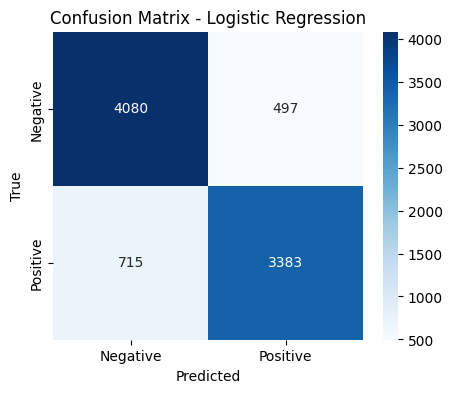

In [18]:
# 5. Confusion Matrix

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Negative","Positive"], yticklabels=["Negative","Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression")
plt.savefig("C:/Users/sairo/Desktop/Myprgms/myGit/Sentiment-Analysis-on-Social-Media-Data/outputs/confusion_matrix.png")
plt.show()


In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, RocCurveDisplay

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, pos_label="Positive")
recall = recall_score(y_val, y_pred, pos_label="Positive")
f1 = f1_score(y_val, y_pred, pos_label="Positive")

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=["Negative", "Positive"]))

Accuracy: 0.860
Precision: 0.872
Recall: 0.826
F1 Score: 0.848

Classification Report:
              precision    recall  f1-score   support

    Negative       0.85      0.89      0.87      4577
    Positive       0.87      0.83      0.85      4098

    accuracy                           0.86      8675
   macro avg       0.86      0.86      0.86      8675
weighted avg       0.86      0.86      0.86      8675



In [19]:
# 6. Deep Learning (LSTM Model)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df["clean_text"])

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_val_pad   = pad_sequences(X_val_seq, maxlen=100)

y_train_bin = (y_train == "Positive").astype(int)
y_val_bin   = (y_val == "Positive").astype(int)

model = Sequential([
    Embedding(input_dim=5000, output_dim=128),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train_pad, y_train_bin, validation_data=(X_val_pad, y_val_bin), epochs=3, batch_size=64)


Epoch 1/3
543/543 ━━━━━━━━━━━━━━━━━━━━ 58s 99ms/step - accuracy: 0.8100 - loss: 0.4004 - val_accuracy: 0.8632 - val_loss: 0.3122
Epoch 2/3
543/543 ━━━━━━━━━━━━━━━━━━━━ 39s 72ms/step - accuracy: 0.8894 - loss: 0.2551 - val_accuracy: 0.8906 - val_loss: 0.2558
Epoch 3/3
543/543 ━━━━━━━━━━━━━━━━━━━━ 43s 79ms/step - accuracy: 0.9122 - loss: 0.1998 - val_accuracy: 0.9019 - val_loss: 0.2326


In [20]:
# 7. Save Model

model.save("C:/Users/sairo/Desktop/Myprgms/myGit/Sentiment-Analysis-on-Social-Media-Data/models/sentiment_model.keras")